# Trying our different learning rate schedules

Using the default network configuration, the goal is to get to the reference valid loss as quickly as possible.

1. Typical learning rate decau
2. One cycle LR

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from src.score import *
from src.utils import *
from src.networks import *
from src.data_generator import *
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [38]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850])}
output_vars = None
filters = [64, 64, 64, 64, 2]
kernels = [5, 5, 5, 5, 5]
lead_time = 72
batch_size = 128
activation = 'elu'

In [39]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [56]:
# ds_train = ds.sel(time=slice('1979', '2015'))
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [57]:
324336 /100000

3.24336

In [59]:
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=batch_size, 
                         output_vars=output_vars, norm_subsample=10000)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
dg_test =  DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
print(f'Mean = {dg_train.mean}; Std = {dg_train.std}')

DG start 09:10:56.383430
DG normalize 09:10:56.401051
DG load 09:11:30.396642
Loading data into RAM
DG done 09:13:37.304046
DG start 09:13:37.304276
DG normalize 09:13:37.312669
DG load 09:13:37.319004
Loading data into RAM
DG done 09:13:40.212086
DG start 09:13:40.212988
DG normalize 09:13:40.223527
DG load 09:13:40.231712
Loading data into RAM
DG done 09:13:47.238962
Mean = <xarray.DataArray 'z' (level: 2)>
array([54079.2    ,   274.53073], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'; Std = <xarray.DataArray 'z' (level: 2)>
array([3414.2642  ,   15.530695], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'


In [60]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54079.2    ,   274.53073], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850',
 <xarray.DataArray 'z' (level: 2)>
 array([3414.2642  ,   15.530695], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850')

## Learning rate decay

In [17]:
class LRUpdate(object):
    def __init__(self, init_lr, step, divide):
        # From goo.gl/GXQaK6
        self.init_lr = init_lr
        self.step = step
        self.drop = 1. / divide

    def __call__(self, epoch):
        lr = self.init_lr * np.power(self.drop, np.floor((epoch) / self.step))
        print(f'Learning rate = {lr}')
        return lr

In [32]:
lrs = LRUpdate(1e-3, 2, 5)

Learning rate = [1.0e-03 1.0e-03 2.0e-04 2.0e-04 4.0e-05 4.0e-05 8.0e-06 8.0e-06 1.6e-06
 1.6e-06]


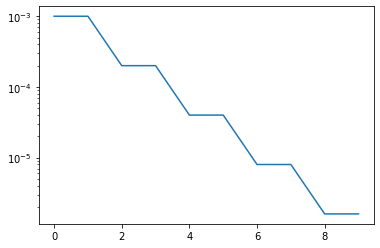

In [33]:
plt.plot(lrs(np.arange(10)))
plt.yscale('log')

In [34]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 64, 2)         0         
_________________________________________________________________
lambda_20 (Lambda)           (None, 36, 68, 2)         0         
_________________________________________________________________
periodic_conv2d_20 (Periodic (None, 32, 64, 64)        3264      
_________________________________________________________________
lambda_21 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_21 (Periodic (None, 32, 64, 64)        102464    
_________________________________________________________________
lambda_22 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_22 (Periodic (None, 32, 64, 64)        102464    
__________

In [ ]:
model.fit_generator(dg_train, epochs=100, validation_data=dg_valid, 
                    callbacks=[keras.callbacks.LearningRateScheduler(lrs)])

Learning rate = 0.001
Epoch 1/100
2534/2534 [==============================] - 177s 70ms/step - loss: 8.0596 - val_loss: 7.3410
Learning rate = 0.001
Epoch 2/100
2534/2534 [==============================] - 178s 70ms/step - loss: 7.0196 - val_loss: 6.8583
Learning rate = 0.0002
Epoch 3/100
2534/2534 [==============================] - 178s 70ms/step - loss: 6.5630 - val_loss: 6.6140
Learning rate = 0.0002
Epoch 4/100
1947/2534 [======================>.......] - ETA: 40s - loss: 6.4614

## One Cycle

In [44]:
from src.clr import LRFinder
import seaborn as sns
sns.set_style('darkgrid')

In [19]:
dg_train.n_samples, batch_size

(324264, 128)

In [29]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-4, maximum_lr=10,
    lr_scale='exp', save_dir='./', verbose=0)

In [30]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [31]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

Epoch 1/1
1009/2534 [==========>...................] - ETA: 1:47 - loss: 568.1512

KeyboardInterrupt: 

(6, 10)

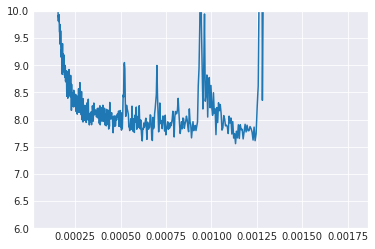

In [45]:
plt.plot(10**lrf.lrs, lrf.losses)
# plt.yscale('log')
plt.ylim(6, 10)

In [81]:
max_lr = 2.5e-4
# max_lr = 5e-4

In [82]:
from src.clr import OneCycleLR

In [83]:
one_cycle = OneCycleLR(max_lr,
    end_percentage=0.1, scale_percentage=None,
#     maximum_momentum=None, minimum_momentum=None
                      )

In [84]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.SGD(), 'mse')

In [85]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2534/2534 [==============================] - 185s 73ms/step - loss: 8.1395 - val_loss: 7.5917
Epoch 2/5
2534/2534 [==============================] - 186s 73ms/step - loss: 7.3380 - val_loss: 7.3206
Epoch 3/5
2534/2534 [==============================] - 185s 73ms/step - loss: 7.0502 - val_loss: 6.9504
Epoch 4/5
2534/2534 [==============================] - 185s 73ms/step - loss: 6.8242 - val_loss: 6.8008
Epoch 5/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6957 - val_loss: 6.7314


In [88]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6846 - val_loss: 6.7612
Epoch 2/5
2534/2534 [==============================] - 185s 73ms/step - loss: 6.6886 - val_loss: 6.7185
Epoch 3/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6221 - val_loss: 6.6198
Epoch 4/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.4922 - val_loss: 6.5067
Epoch 5/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.4067 - val_loss: 6.4583


In [89]:
one_cycle = OneCycleLR(max_lr,
    end_percentage=0.1, scale_percentage=None,
    maximum_momentum=None, minimum_momentum=None
                      )

In [90]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [ ]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2380/2534 [===========================>..] - ETA: 11s - loss: 9.0376

In [ ]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

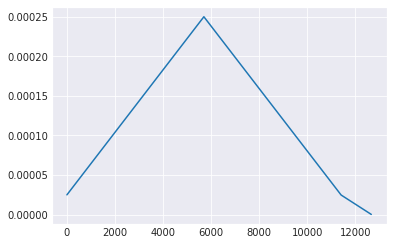

In [86]:
plt.plot(one_cycle.history['lr'])

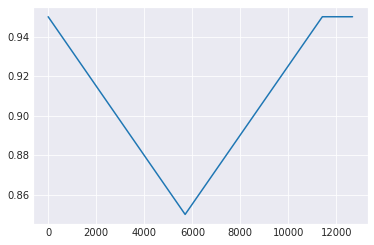

In [87]:
plt.plot(one_cycle.history['momentum'])

## Compare different schedules

In [5]:
from src.utils import *

In [6]:
!ls /home/stephan/data/myWeatherBench/predictions/saved_models/*hist*

/home/stephan/data/myWeatherBench/predictions/saved_models/01.1-default_no_es_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/02-6h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/03-12h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/04-36h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/05-2.5e-4_no_decay_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/06-decay_10_5_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/07-decay_40_10_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/08-2.5e-4_es_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/09-no_periodic_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/10-big_fc_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/11-add_orography_history.pkl
/home/stephan/data/myWeatherBench/predictions/s

In [7]:
h01 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/01.1-default_no_es_history.pkl')
h05 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/05-2.5e-4_no_decay_history.pkl')
h06 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/06-decay_10_5_history.pkl')
h07 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/07-decay_40_10_history.pkl')
h08 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/08-2.5e-4_es_history.pkl')

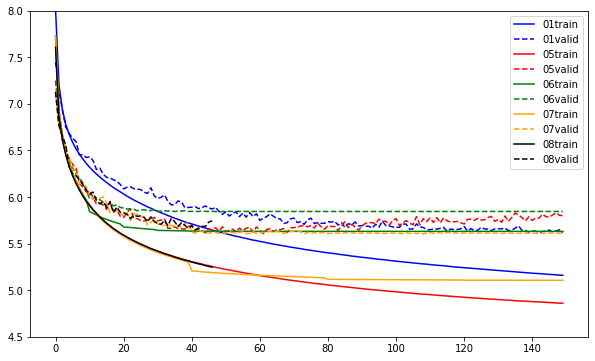

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip([h01, h05, h06, h07, h08], ['01', '05', '06', '07', '08'], 
                      ['b', 'r', 'g', 'orange', 'black']):
    plot_hist(h, ax, (4.5, 8), name, valid=False, c=c)
    plot_hist(h, ax, (4.5, 8), name, train=False, c=c, ls='--')

In [9]:
for h in [h01, h05, h06, h07, h08]:
    print(np.min(h['val_loss']), np.argmin(h['val_loss']))

5.617629877627717 142
5.606985253270774 61
5.841095121137805 48
5.601057487605798 73
5.648159567208548 41


## LR schedule for big network

In [10]:
h10 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/10-big_fc_history.pkl')

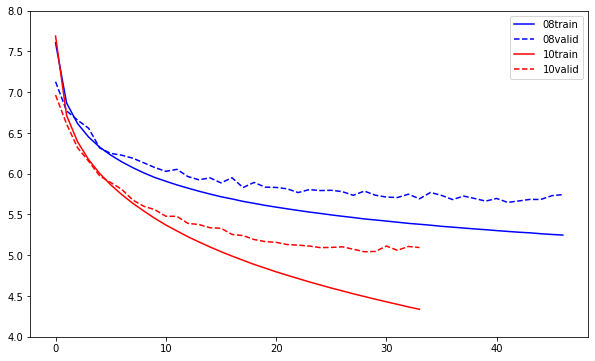

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip([h08, h10], ['08', '10'], 
                      ['b', 'r']):
    plot_hist(h, ax, (4, 8), name, valid=False, c=c)
    plot_hist(h, ax, (4, 8), name, train=False, c=c, ls='--')

In [61]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-5, maximum_lr=1,
    lr_scale='exp', save_dir='./', verbose=0)

In [62]:
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]

In [63]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [64]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

Epoch 1/1
 410/1096 [==========>...................] - ETA: 2:21 - loss: 2836.7694

KeyboardInterrupt: 

(7, 11)

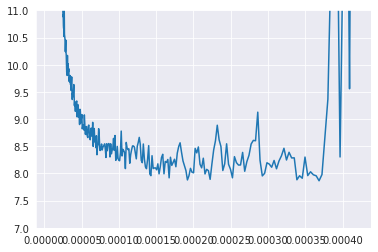

In [71]:
plt.plot(10**lrf.lrs, lrf.losses)
plt.ylim(7, 11)


In [72]:
tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          mode='auto',
                          restore_best_weights=True
                      )

TypeError: __init__() got an unexpected keyword argument 'restore_best_weights'

## NEW: Check learning curves

In [4]:
h13 = read_pickle(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/13-resnet_bn_dr_0.1_history.pkl')

In [5]:
h17 = read_pickle(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/17-resnet_deeper_bn_dr_0.1_history.pkl')

In [9]:
??plot_hist

Signature: plot_hist(h, ax=None, ylim=None, name='', train=True, valid=True, **kwargs)
Docstring: <no docstring>
Source:   
def plot_hist(h, ax=None, ylim=None, name='', train=True, valid=True, **kwargs):
    if ax is None: fig, ax = plt.subplots()
    if train: ax.plot(h['loss'], label=f'{name}train', **kwargs)
    if valid: ax.plot(h['val_loss'], label=f'{name}valid', **kwargs)
    ax.legend()
    if ylim is not None: ax.set_ylim(ylim)
File:      ~/repositories/myWeatherBench/devlog/src/utils.py
Type:      function


In [13]:
from glob import glob

In [14]:
path = '/home/rasp/data/myWeatherBench/predictions/saved_models/'

In [18]:
glob(f'{path}14*pkl')

['/home/rasp/data/myWeatherBench/predictions/saved_models/14-resnet_bn_l2_1e-5_history.pkl']

In [19]:
sns.palettes.color_palette(n_colors=5)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [27]:
def plot_losses(path, exp_ids, plot_lrs=True, ylim=None):
    exp_ids = [str(exp_id) for exp_id in exp_ids]
    fig, axs = plt.subplots(2 if plot_lrs else 1, 1, figsize=(10, 10 if plot_lrs else 5))
    colors = sns.palettes.color_palette(n_colors=len(exp_ids))
    for exp_id, c, in zip(exp_ids, colors):
        fn = glob(f'{path}{exp_id}*.pkl')[0]
        h = read_pickle(fn)
        plot_hist(h, axs[0], name=exp_id, valid=False, c=c)
        plot_hist(h, axs[0], name=exp_id, train=False, c=c, ls='--')
        axs[0].set_ylim(ylim)
        
        if plot_lrs:
            axs[1].plot(h['lr'], c=c)

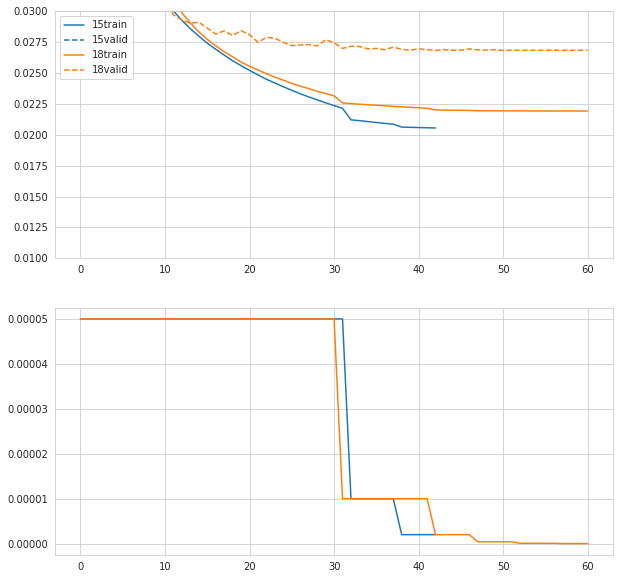

In [29]:
plot_losses(path, [15, 18], ylim=(0.01, 0.03))

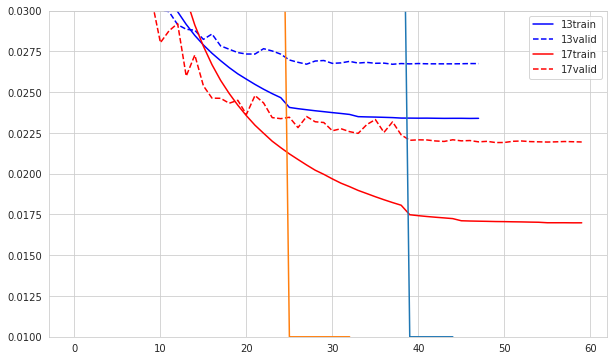

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip([h13, h17], ['13', '17'], 
                      ['b', 'r']):
    plot_hist(h, ax, name=name, valid=False, c=c)
    plot_hist(h, ax, name=name, train=False, c=c, ls='--')
plt.ylim(0.01, 0.03)
# plt.yscale('log')
plt.plot(np.array((h17['lr']))*1e3)
plt.plot(np.array((h13['lr']))*1e3)

In [32]:
h29 = read_pickle(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/29-resnet_hr_history.pkl')
h33 = read_pickle(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/33-resnet_hr_pre_history.pkl')

In [34]:
h33

{}

KeyError: 'loss'

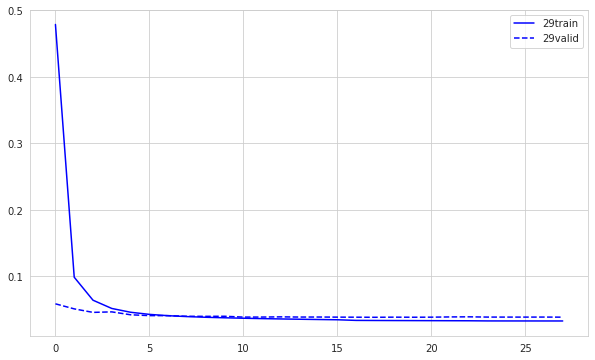

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip([h29, h33], ['29', '33'], 
                      ['b', 'r']):
    plot_hist(h, ax, name=name, valid=False, c=c)
    plot_hist(h, ax, name=name, train=False, c=c, ls='--')

## Again: Check learning curves. Does it need to take so long!?

In [32]:
path = '/home/rasp/data/myWeatherBench/predictions/saved_models/'

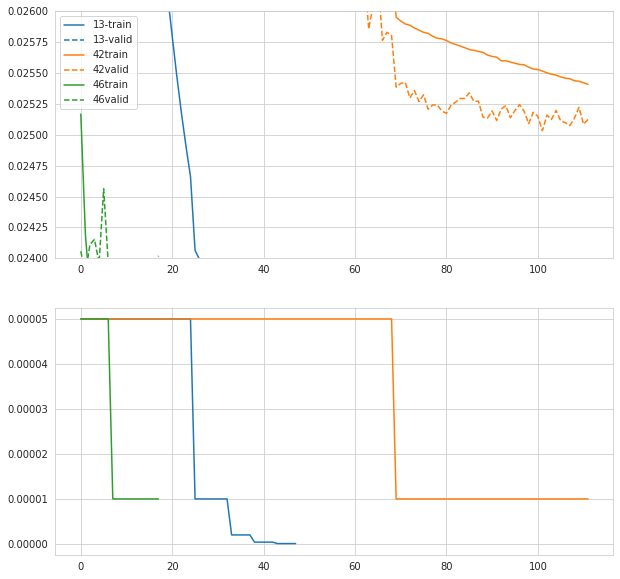

In [42]:
plot_losses(path, ['13-', 42, 46], ylim=(0.024, 0.026))

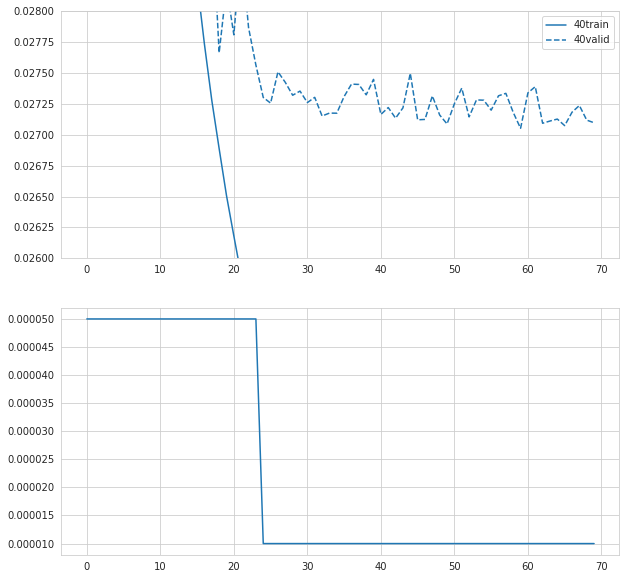

In [45]:
plot_losses(path, [40], ylim=(0.026, 0.028))

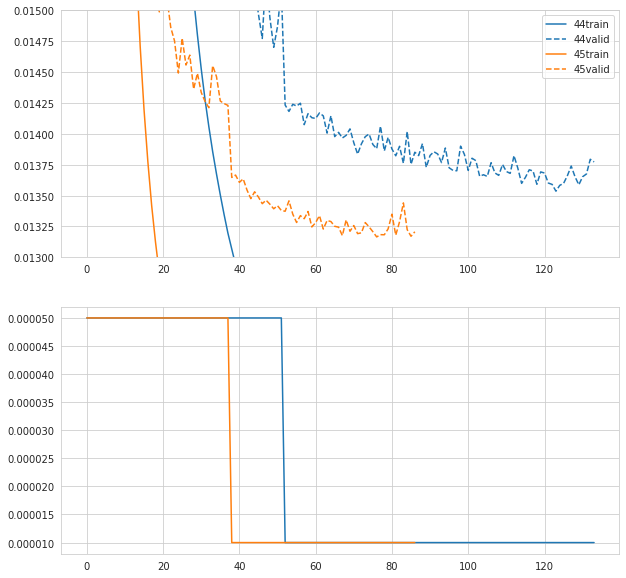

In [48]:
plot_losses(path, [44, 45], ylim=(0.013, 0.015))

In [55]:
fn = '/home/rasp/data/myWeatherBench/predictions/saved_models/29-resnet_hr_history.pkl'

In [57]:
with open(fn, 'wb') as f:
    print('a')

a
